Step 1: Load and preprocess the Reuters dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Reuters dataset
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# Preprocess the data
max_len = 2400  # Limiting sequence length to 200 for padding
train_data = pad_sequences(train_data, maxlen=max_len, padding='post')
test_data = pad_sequences(test_data, maxlen=max_len, padding='post')

from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=46)
test_labels = to_categorical(test_labels, num_classes=46)

2110848/2110848 [==============================] - 0s 0us/step


Step 2: Define a custom RingAttention layer implementing ring attention.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class RingAttention(Layer):
    def __init__(self, num_heads=8, key_dim=128, **kwargs):
        super(RingAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim

    def build(self, input_shape):
        self.query_dense = Dense(self.key_dim, use_bias=False)
        self.key_dense = Dense(self.key_dim, use_bias=False)
        self.value_dense = Dense(self.key_dim, use_bias=False)
        super(RingAttention, self).build(input_shape)

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Reshape for multi-head attention
        query = tf.reshape(query, (-1, tf.shape(query)[1], self.num_heads, self.key_dim // self.num_heads))
        key = tf.reshape(key, (-1, tf.shape(key)[1], self.num_heads, self.key_dim // self.num_heads))
        value = tf.reshape(value, (-1, tf.shape(value)[1], self.num_heads, self.key_dim // self.num_heads))

        # Transpose for attention calculation
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.transpose(value, perm=[0, 2, 1, 3])

        # Circular shift on keys
        key = tf.concat([key[:, :, -1:, :], key[:, :, :-1, :]], axis=-2)

        # Calculate attention scores
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        # Apply attention to values
        output = tf.matmul(attention_scores, value)

        # Transpose and reshape back to original shape
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (-1, tf.shape(output)[1], self.key_dim))

        return output

Step 3: Define a custom BlockwiseTransformer layer consisting of multiple blocks of ring attention and feed-forward networks.

In [ ]:
from tensorflow.keras.layers import LayerNormalization

class BlockwiseTransformer(Layer):
    def __init__(self, num_blocks=6, embed_dim=128, num_heads=8, mlp_dim=128, dropout=0.1, **kwargs):
        super(BlockwiseTransformer, self).__init__(**kwargs)
        self.num_blocks = num_blocks
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.attention_layers = [RingAttention(num_heads=self.num_heads, key_dim=self.embed_dim) for _ in range(self.num_blocks)]
        self.ffn_layers = [tf.keras.Sequential([
            Dense(self.mlp_dim, activation='relu'),
            Dense(self.embed_dim)
        ]) for _ in range(self.num_blocks)]
        self.layernorm1 = [LayerNormalization(epsilon=1e-6) for _ in range(self.num_blocks)]
        self.layernorm2 = [LayerNormalization(epsilon=1e-6) for _ in range(self.num_blocks)]
        super(BlockwiseTransformer, self).build(input_shape)

    def call(self, inputs):
        x = inputs

        for i in range(self.num_blocks):
            # Ring attention
            attn_output = self.attention_layers[i](x)
            attn_output = self.layernorm1[i](attn_output + x)

            # Feed-forward MLP
            ffn_output = self.ffn_layers[i](attn_output)
            x = self.layernorm2[i](ffn_output + attn_output)

        return x

In [ ]:
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def build_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=10000, output_dim=128)(inputs)  # Embedding layer
    x = BlockwiseTransformer(num_blocks=6, embed_dim=128, num_heads=8, mlp_dim=128, dropout=0.1)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(46, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_data, train_labels, epochs=20, batch_size=16, validation_split=0.1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
506/506 [==============================] - 169s 304ms/step - loss: 1.8913 - accuracy: 0.5319 - val_loss: 1.7070 - val_accuracy: 0.5818
Epoch 2/20
506/506 [==============================] - 152s 301ms/step - loss: 1.4487 - accuracy: 0.6418 - val_loss: 1.4669 - val_accuracy: 0.6518
Epoch 3/20
506/506 [==============================] - 152s 301ms/step - loss: 1.2879 - accuracy: 0.6740 - val_loss: 1.4746 - val_accuracy: 0.6452
Epoch 4/20
506/506 [==============================] - 152s 301ms/step - loss: 1.3447 - accuracy: 0.6611 - val_loss: 1.5229 - val_accuracy: 0.6396
Epoch 5/20
506/506 [==============================] - 153s 302ms/step - loss: 1.3618 - accuracy: 0.6546 - val_loss: 1.3978 - val_accuracy: 0.6596
Epoch 6/20
506/506 [==============================] - 153s 302ms/step - loss: 1.2926 - accuracy: 0.6730 - val_loss: 1.5763 - val_accuracy: 0.6174
Epoch 7/20
506/506 [==============================] - 153s 302ms/step - loss: 1.3312 - accuracy: 0.6525 - val_loss: 1.4549 -

Plotting the training and validation loss

In [ ]:
import matplotlib.pyplot as plt

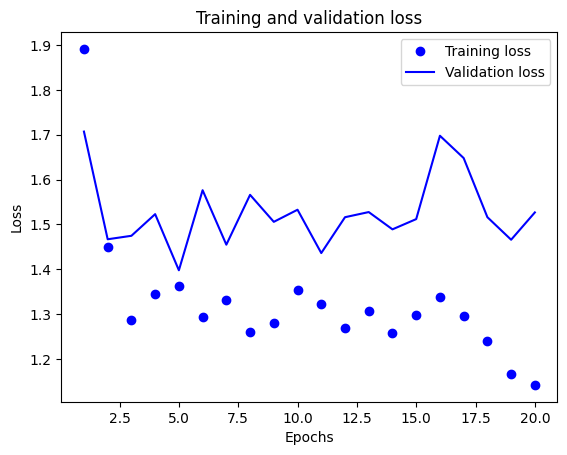

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Plotting the training and validation accuracy

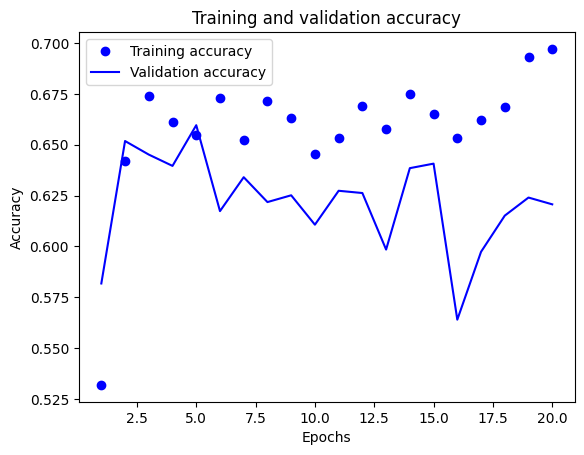

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model.predict(test_data)

71/71 [==============================] - 15s 188ms/step


array([[1.0726145e-03, 5.6907292e-03, 1.9558841e-04, ..., 1.8137848e-04,
        1.9688503e-04, 3.1253643e-04],
       [1.8629158e-01, 3.2643944e-02, 5.8063123e-02, ..., 5.3238615e-05,
        1.8190364e-03, 2.0087799e-03],
       [1.7209910e-02, 3.5849777e-01, 3.2625992e-02, ..., 2.1499154e-06,
        1.9892195e-04, 8.8441925e-04],
       ...,
       [1.4913431e-04, 2.5115130e-03, 4.7605587e-05, ..., 1.7771425e-05,
        8.4747728e-05, 2.7966482e-05],
       [4.3696823e-04, 2.8761392e-03, 9.3399678e-05, ..., 6.7774650e-05,
        3.5720438e-04, 2.2796332e-04],
       [2.7626574e-03, 6.9671595e-01, 1.2246839e-02, ..., 2.5650272e-06,
        2.4779740e-04, 5.0439307e-05]], dtype=float32)